In [33]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/personal/graph2vec_embeddings.npy
/kaggle/input/personal/graph2vec_labels.npy


In [34]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:0000:01


In [35]:
import torch
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, BatchNorm
from collections import defaultdict
import json
import networkx as nx
from torch import nn
import math
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split

In [36]:
embedding = np.load("/kaggle/input/personal/graph2vec_embeddings.npy")
labels = np.load("/kaggle/input/personal/graph2vec_labels.npy")

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
!rm -rf checkpoints results training_history

In [39]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [40]:
class NodeClassificationGNN(nn.Module):
    def __init__(self, input_dim, hidden_channel, num_classes, dropout=0.3, activation=nn.LeakyReLU):
        super().__init__()
        self.activation = activation()  # Initialize activation function
        self.conv1 = SAGEConv(input_dim, hidden_channel)
        self.bn1 = BatchNorm(hidden_channel)  # BatchNorm for first layer
        self.conv2 = SAGEConv(hidden_channel, hidden_channel)
        self.bn2 = BatchNorm(hidden_channel)  # BatchNorm for second layer
        self.dropout = nn.Dropout(dropout)
        
        # MLP for final classification
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channel, hidden_channel),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_channel, num_classes)
        )

    def forward(self, x, edge_index):
        # First convolutional layer with batch normalization and activation
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Second convolutional layer with batch normalization and activation
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Pass through the MLP for final predictions
        x = self.mlp(x)
        return x


In [41]:
def build_similarity_graph(embeddings, threshold):
    num_nodes = embeddings.shape[0]
    similarity_matrix = cosine_similarity(embeddings)

    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, embedding=embeddings[i])

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G

def convert_to_torch_geometric(graph):
    node_features = np.array([graph.nodes[n]['embedding'] for n in graph.nodes])
    edge_index = np.array(list(graph.edges)).T
    edge_weights = np.array([graph[u][v]['weight'] for u, v in graph.edges])

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights)

    return data

def split_data(data, labels, train_ratio=0.7, val_ratio=0.2):
    train_idx, temp_idx, train_labels, temp_labels = train_test_split(
        np.arange(len(labels)), labels, test_size=(1 - train_ratio), stratify=labels
    )
    val_size = val_ratio / (1 - train_ratio)
    val_idx, test_idx, val_labels, test_labels = train_test_split(
        temp_idx, temp_labels, test_size=(1 - val_size), stratify=temp_labels
    )
    return train_idx, val_idx, test_idx

def load_best_model(model, threshold, save_path='checkpoints'):
    checkpoint = torch.load(os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return checkpoint['best_val_loss']

def save_training_history(history, threshold, save_path='training_history'):
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f'history_threshold_{threshold:.2f}.json'), 'w') as f:
        json.dump(history, f, indent=4)

In [42]:
def train(optimizer, criterion, model, data, _, threshold, save_path='checkpoints', num_epochs=300):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                         factor=0.5, patience=10, 
                                                         min_lr=1e-6, verbose=True)
    
    history = defaultdict(list)
    os.makedirs(save_path, exist_ok=True)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
        train_acc = correct / data.train_mask.sum().item()

        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            val_pred = val_out.argmax(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / data.val_mask.sum().item()

        scheduler.step(val_loss)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                  f"Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
    save_training_history(history, threshold)
    
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    return best_val_loss, history


In [54]:
def build_graphs_and_setup_model(embedding, thresholds=[0.15]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_test_acc = 0
    all_results = {}
    
    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        train_idx, val_idx, test_idx = split_data(data, labels)
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        data.train_mask = train_mask
        data.val_mask = val_mask
        data.test_mask = test_mask
        data = data.to(device)
        
        model = NodeClassificationGNN(input_dim=128, hidden_channel=512, num_classes=len(np.unique(labels)), dropout=0.7).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        criterion = torch.nn.CrossEntropyLoss()
        _, history = train(optimizer, criterion, model, data, labels, threshold)
        model.eval()
        with torch.no_grad():
            test_out = model(data.x, data.edge_index)
            test_pred = test_out.argmax(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / data.test_mask.sum().item()
        print(f"Test Accuracy: {test_acc:.4f}")
        
        all_results[threshold] = {
            'test_accuracy': test_acc,
            'training_history': history
        }
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_threshold = threshold
    
    if not os.path.exists('results'):
        os.makedirs('results')


    with open('results/overall_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_test_accuracy': best_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Test Accuracy: {best_test_acc:.4f}")

In [48]:
def build_graphs_and_setup_model_cv(embedding, labels, thresholds=np.arange(0.05, 0.16, 0.01), n_splits=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_avg_test_acc = 0
    all_results = {}

    train_idx, test_idx = train_test_split(
        np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=42
    )

    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask[test_idx] = True
        data.test_mask = test_mask
        data = data.to(device)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_test_accuracies = []

        for fold, (train_sub_idx, val_idx) in enumerate(skf.split(train_idx, labels[train_idx])):
            print(f"  Fold {fold + 1}/{n_splits}")

            train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
            val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)

            train_mask[train_idx[train_sub_idx]] = True
            val_mask[train_idx[val_idx]] = True

            data.train_mask = train_mask
            data.val_mask = val_mask

            # Model and optimizer
            input_dim = 128
            hidden_channels = 256
            out_ch = len(np.unique(labels))
            model = NodeClassificationGNN(
                input_dim=input_dim, hidden_channel=hidden_channels, num_classes=out_ch, dropout=0.7
            ).to(device)
            print(f"Model: input_dim: {input_dim}, hidden_channels: {hidden_channels}, output_dim: {out_ch}")
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
            criterion = torch.nn.CrossEntropyLoss()

            _, history = train(optimizer, criterion, model, data, labels, threshold)
            model.eval()

            # Evaluate on the test set
            with torch.no_grad():
                test_out = model(data.x, data.edge_index)
                test_pred = test_out.argmax(dim=1)
                test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
                test_acc = test_correct / data.test_mask.sum().item()

            print(f"Fold Test Accuracy: {test_acc:.4f}")
            fold_test_accuracies.append(test_acc)

        avg_test_acc = sum(fold_test_accuracies) / n_splits
        print(f"  Average Test Accuracy for Threshold {threshold:.2f}: {avg_test_acc:.4f}")

        all_results[threshold] = {
            'avg_test_accuracy': avg_test_acc,
            'test_accuracies': fold_test_accuracies,
        }
        if avg_test_acc > best_avg_test_acc:
            best_avg_test_acc = avg_test_acc
            best_threshold = threshold

    if not os.path.exists('results'):
        os.makedirs('results')

    with open('results/cv_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_avg_test_accuracy': best_avg_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Average Test Accuracy: {best_avg_test_acc:.4f}")


In [42]:
build_graphs_and_setup_model_cv(embedding, labels)


Training with threshold: 0.05
  Fold 1/5
Model: input_dim: 128, hidden_channels: 256, output_dim: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6860, Val Loss: 2.5621, Acc: 0.0874, Val Acc: 0.0710
Epoch 10, Loss: 2.4564, Val Loss: 2.4301, Acc: 0.1620, Val Acc: 0.2670
Epoch 20, Loss: 2.1716, Val Loss: 2.1280, Acc: 0.2438, Val Acc: 0.3068
Epoch 30, Loss: 1.9451, Val Loss: 1.8716, Acc: 0.3014, Val Acc: 0.3295
Epoch 40, Loss: 1.7234, Val Loss: 1.6138, Acc: 0.3483, Val Acc: 0.4261
Epoch 50, Loss: 1.5178, Val Loss: 1.3539, Acc: 0.4193, Val Acc: 0.5256
Epoch 60, Loss: 1.3492, Val Loss: 1.1453, Acc: 0.4591, Val Acc: 0.6278
Epoch 70, Loss: 1.1841, Val Loss: 0.9902, Acc: 0.5288, Val Acc: 0.6818
Epoch 80, Loss: 1.0237, Val Loss: 0.8568, Acc: 0.5977, Val Acc: 0.6960
Epoch 90, Loss: 0.8935, Val Loss: 0.7654, Acc: 0.6418, Val Acc: 0.7159
Epoch 100, Loss: 0.8052, Val Loss: 0.7173, Acc: 0.6901, Val Acc: 0.7159
Epoch 110, Loss: 0.7343, Val Loss: 0.6757, Acc: 0.7072, Val Acc: 0.7188
Epoch 120, Loss: 0.6767, Val Loss: 0.6578, Acc: 0.7299, Val Acc: 0.7159
Epoch 130, Loss: 0.6175, Val Loss: 0.7280, Acc: 0.7491, Val Acc: 0.6761
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7127, Val Loss: 2.5595, Acc: 0.0746, Val Acc: 0.1193
Epoch 10, Loss: 2.4665, Val Loss: 2.4426, Acc: 0.1692, Val Acc: 0.2614
Epoch 20, Loss: 2.1913, Val Loss: 2.1493, Acc: 0.2473, Val Acc: 0.2812
Epoch 30, Loss: 1.9555, Val Loss: 1.8876, Acc: 0.2971, Val Acc: 0.3466
Epoch 40, Loss: 1.7045, Val Loss: 1.6246, Acc: 0.3603, Val Acc: 0.4347
Epoch 50, Loss: 1.5195, Val Loss: 1.3692, Acc: 0.3959, Val Acc: 0.5284
Epoch 60, Loss: 1.3222, Val Loss: 1.1386, Acc: 0.4726, Val Acc: 0.6392
Epoch 70, Loss: 1.1600, Val Loss: 0.9929, Acc: 0.5409, Val Acc: 0.6705
Epoch 80, Loss: 1.0104, Val Loss: 0.8778, Acc: 0.5963, Val Acc: 0.6818
Epoch 90, Loss: 0.8997, Val Loss: 0.7318, Acc: 0.6354, Val Acc: 0.7273
Epoch 100, Loss: 0.8146, Val Loss: 0.6911, Acc: 0.6617, Val Acc: 0.7358
Epoch 110, Loss: 0.7305, Val Loss: 0.7284, Acc: 0.7129, Val Acc: 0.6790
Epoch 120, Loss: 0.6806, Val Loss: 0.6448, Acc: 0.7207, Val Acc: 0.7301
Epoch 130, Loss: 0.6641, Val Loss: 0.5720, Acc: 0.7178, Val Acc: 0.7585
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6852, Val Loss: 2.5579, Acc: 0.0881, Val Acc: 0.1051
Epoch 10, Loss: 2.4424, Val Loss: 2.4243, Acc: 0.1578, Val Acc: 0.2926
Epoch 20, Loss: 2.1791, Val Loss: 2.1112, Acc: 0.2381, Val Acc: 0.2926
Epoch 30, Loss: 1.9386, Val Loss: 1.8590, Acc: 0.2814, Val Acc: 0.3551
Epoch 40, Loss: 1.7129, Val Loss: 1.6126, Acc: 0.3539, Val Acc: 0.4119
Epoch 50, Loss: 1.5307, Val Loss: 1.3808, Acc: 0.3994, Val Acc: 0.5170
Epoch 60, Loss: 1.3311, Val Loss: 1.1946, Acc: 0.4805, Val Acc: 0.6165
Epoch 70, Loss: 1.1556, Val Loss: 1.0389, Acc: 0.5480, Val Acc: 0.6477
Epoch 80, Loss: 1.0488, Val Loss: 0.8864, Acc: 0.5593, Val Acc: 0.6932
Epoch 90, Loss: 0.9010, Val Loss: 0.7962, Acc: 0.6453, Val Acc: 0.6960
Epoch 100, Loss: 0.7862, Val Loss: 0.7445, Acc: 0.6944, Val Acc: 0.6790
Epoch 110, Loss: 0.7094, Val Loss: 0.7348, Acc: 0.7143, Val Acc: 0.6591
Epoch 120, Loss: 0.6697, Val Loss: 0.7022, Acc: 0.7299, Val Acc: 0.7102
Epoch 130, Loss: 0.6132, Val Loss: 0.6185, Acc: 0.7612, Val Acc: 0.7216
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6936, Val Loss: 2.5617, Acc: 0.0924, Val Acc: 0.0653
Epoch 10, Loss: 2.4489, Val Loss: 2.4232, Acc: 0.1564, Val Acc: 0.3210
Epoch 20, Loss: 2.1676, Val Loss: 2.1200, Acc: 0.2488, Val Acc: 0.3125
Epoch 30, Loss: 1.9530, Val Loss: 1.8775, Acc: 0.3099, Val Acc: 0.3523
Epoch 40, Loss: 1.7302, Val Loss: 1.6478, Acc: 0.3426, Val Acc: 0.4631
Epoch 50, Loss: 1.5161, Val Loss: 1.4039, Acc: 0.4136, Val Acc: 0.5227
Epoch 60, Loss: 1.3647, Val Loss: 1.1730, Acc: 0.4726, Val Acc: 0.6080
Epoch 70, Loss: 1.1812, Val Loss: 1.0131, Acc: 0.5402, Val Acc: 0.6705
Epoch 80, Loss: 1.0393, Val Loss: 0.8801, Acc: 0.5814, Val Acc: 0.7102
Epoch 90, Loss: 0.9048, Val Loss: 0.7618, Acc: 0.6326, Val Acc: 0.7216
Epoch 100, Loss: 0.8127, Val Loss: 0.7205, Acc: 0.6766, Val Acc: 0.7216
Epoch 110, Loss: 0.6931, Val Loss: 0.7414, Acc: 0.7377, Val Acc: 0.6591
Epoch 120, Loss: 0.6646, Val Loss: 0.7152, Acc: 0.7363, Val Acc: 0.6676
Epoch 130, Loss: 0.6707, Val Loss: 0.6701, Acc: 0.7299, Val Acc: 0.6989
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7183, Val Loss: 2.5630, Acc: 0.0704, Val Acc: 0.0767
Epoch 10, Loss: 2.4880, Val Loss: 2.4392, Acc: 0.1350, Val Acc: 0.2784
Epoch 20, Loss: 2.2135, Val Loss: 2.1547, Acc: 0.2239, Val Acc: 0.3153
Epoch 30, Loss: 1.9659, Val Loss: 1.8793, Acc: 0.2971, Val Acc: 0.3580
Epoch 40, Loss: 1.7491, Val Loss: 1.6220, Acc: 0.3376, Val Acc: 0.4403
Epoch 50, Loss: 1.5509, Val Loss: 1.3929, Acc: 0.3916, Val Acc: 0.5199
Epoch 60, Loss: 1.3510, Val Loss: 1.1958, Acc: 0.4534, Val Acc: 0.6051
Epoch 70, Loss: 1.2129, Val Loss: 1.0393, Acc: 0.5096, Val Acc: 0.6619
Epoch 80, Loss: 1.0622, Val Loss: 0.8935, Acc: 0.5821, Val Acc: 0.6818
Epoch 90, Loss: 0.9469, Val Loss: 0.7857, Acc: 0.6290, Val Acc: 0.7159
Epoch 100, Loss: 0.8512, Val Loss: 0.7268, Acc: 0.6468, Val Acc: 0.7017
Epoch 110, Loss: 0.7565, Val Loss: 0.7244, Acc: 0.6965, Val Acc: 0.6989
Epoch 120, Loss: 0.7073, Val Loss: 0.6548, Acc: 0.7178, Val Acc: 0.7301
Epoch 130, Loss: 0.6828, Val Loss: 0.6159, Acc: 0.7200, Val Acc: 0.7528
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7306, Val Loss: 2.5603, Acc: 0.0718, Val Acc: 0.1023
Epoch 10, Loss: 2.4659, Val Loss: 2.4448, Acc: 0.1500, Val Acc: 0.2642
Epoch 20, Loss: 2.1907, Val Loss: 2.1427, Acc: 0.2345, Val Acc: 0.2699
Epoch 30, Loss: 1.9472, Val Loss: 1.8675, Acc: 0.3134, Val Acc: 0.3381
Epoch 40, Loss: 1.7042, Val Loss: 1.6206, Acc: 0.3511, Val Acc: 0.4403
Epoch 50, Loss: 1.5147, Val Loss: 1.3766, Acc: 0.4051, Val Acc: 0.5341
Epoch 60, Loss: 1.3323, Val Loss: 1.1665, Acc: 0.4819, Val Acc: 0.6477
Epoch 70, Loss: 1.1569, Val Loss: 1.0175, Acc: 0.5565, Val Acc: 0.6676
Epoch 80, Loss: 1.0159, Val Loss: 0.8491, Acc: 0.5970, Val Acc: 0.7159
Epoch 90, Loss: 0.9049, Val Loss: 0.7470, Acc: 0.6389, Val Acc: 0.7415
Epoch 100, Loss: 0.8055, Val Loss: 0.7550, Acc: 0.6702, Val Acc: 0.6875
Epoch 110, Loss: 0.7503, Val Loss: 0.7305, Acc: 0.6930, Val Acc: 0.6761
Epoch 120, Loss: 0.7039, Val Loss: 0.6710, Acc: 0.7164, Val Acc: 0.7159
Epoch 130, Loss: 0.6682, Val Loss: 0.6390, Acc: 0.7200, Val Acc: 0.7415
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7023, Val Loss: 2.5568, Acc: 0.0725, Val Acc: 0.0881
Epoch 10, Loss: 2.4498, Val Loss: 2.4275, Acc: 0.1613, Val Acc: 0.2273
Epoch 20, Loss: 2.1942, Val Loss: 2.1453, Acc: 0.2324, Val Acc: 0.2528
Epoch 30, Loss: 1.9509, Val Loss: 1.8878, Acc: 0.2736, Val Acc: 0.3125
Epoch 40, Loss: 1.7611, Val Loss: 1.6508, Acc: 0.3220, Val Acc: 0.3693
Epoch 50, Loss: 1.5518, Val Loss: 1.4318, Acc: 0.4108, Val Acc: 0.4830
Epoch 60, Loss: 1.3616, Val Loss: 1.2235, Acc: 0.4833, Val Acc: 0.5767
Epoch 70, Loss: 1.2078, Val Loss: 1.0593, Acc: 0.5338, Val Acc: 0.6165
Epoch 80, Loss: 1.0627, Val Loss: 0.9380, Acc: 0.5771, Val Acc: 0.6477
Epoch 90, Loss: 0.9544, Val Loss: 0.8308, Acc: 0.6233, Val Acc: 0.6676
Epoch 100, Loss: 0.8434, Val Loss: 0.7411, Acc: 0.6453, Val Acc: 0.7074
Epoch 110, Loss: 0.7272, Val Loss: 0.7257, Acc: 0.7086, Val Acc: 0.7159
Epoch 120, Loss: 0.6723, Val Loss: 0.7096, Acc: 0.7370, Val Acc: 0.6847
Epoch 130, Loss: 0.6179, Val Loss: 0.6965, Acc: 0.7527, Val Acc: 0.6960
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7403, Val Loss: 2.5624, Acc: 0.0839, Val Acc: 0.0824
Epoch 10, Loss: 2.4727, Val Loss: 2.4447, Acc: 0.1713, Val Acc: 0.3097
Epoch 20, Loss: 2.1775, Val Loss: 2.1307, Acc: 0.2388, Val Acc: 0.3381
Epoch 30, Loss: 1.9375, Val Loss: 1.8370, Acc: 0.3099, Val Acc: 0.3693
Epoch 40, Loss: 1.6860, Val Loss: 1.5664, Acc: 0.3618, Val Acc: 0.4545
Epoch 50, Loss: 1.4803, Val Loss: 1.3282, Acc: 0.4236, Val Acc: 0.5540
Epoch 60, Loss: 1.3168, Val Loss: 1.1083, Acc: 0.4783, Val Acc: 0.6676
Epoch 70, Loss: 1.1161, Val Loss: 0.9460, Acc: 0.5593, Val Acc: 0.6960
Epoch 80, Loss: 0.9909, Val Loss: 0.8147, Acc: 0.6077, Val Acc: 0.7188
Epoch 90, Loss: 0.8908, Val Loss: 0.7360, Acc: 0.6539, Val Acc: 0.7330
Epoch 100, Loss: 0.8027, Val Loss: 0.7015, Acc: 0.6731, Val Acc: 0.7159
Epoch 110, Loss: 0.7207, Val Loss: 0.7608, Acc: 0.7022, Val Acc: 0.6506
Epoch 120, Loss: 0.6650, Val Loss: 0.6695, Acc: 0.7406, Val Acc: 0.7131
Epoch 130, Loss: 0.6539, Val Loss: 0.6154, Acc: 0.7392, Val Acc: 0.7386
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6729, Val Loss: 2.5627, Acc: 0.0824, Val Acc: 0.0767
Epoch 10, Loss: 2.4583, Val Loss: 2.4299, Acc: 0.1571, Val Acc: 0.2642
Epoch 20, Loss: 2.2000, Val Loss: 2.1719, Acc: 0.2338, Val Acc: 0.2670
Epoch 30, Loss: 1.9910, Val Loss: 1.9311, Acc: 0.2850, Val Acc: 0.3523
Epoch 40, Loss: 1.7509, Val Loss: 1.6730, Acc: 0.3255, Val Acc: 0.4205
Epoch 50, Loss: 1.5559, Val Loss: 1.4050, Acc: 0.3952, Val Acc: 0.5398
Epoch 60, Loss: 1.3783, Val Loss: 1.1871, Acc: 0.4613, Val Acc: 0.6364
Epoch 70, Loss: 1.1941, Val Loss: 1.0260, Acc: 0.5316, Val Acc: 0.6619
Epoch 80, Loss: 1.0789, Val Loss: 0.8669, Acc: 0.5743, Val Acc: 0.7273
Epoch 90, Loss: 0.9072, Val Loss: 0.7501, Acc: 0.6482, Val Acc: 0.7159
Epoch 100, Loss: 0.8308, Val Loss: 0.7072, Acc: 0.6660, Val Acc: 0.7074
Epoch 110, Loss: 0.7454, Val Loss: 0.7115, Acc: 0.6908, Val Acc: 0.6818
Epoch 120, Loss: 0.6552, Val Loss: 0.6806, Acc: 0.7321, Val Acc: 0.6932
Epoch 130, Loss: 0.6145, Val Loss: 0.6386, Acc: 0.7633, Val Acc: 0.7131
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6951, Val Loss: 2.5624, Acc: 0.0839, Val Acc: 0.1108
Epoch 10, Loss: 2.4548, Val Loss: 2.4490, Acc: 0.1564, Val Acc: 0.2386
Epoch 20, Loss: 2.1861, Val Loss: 2.1414, Acc: 0.2388, Val Acc: 0.3011
Epoch 30, Loss: 1.9590, Val Loss: 1.8662, Acc: 0.2772, Val Acc: 0.3551
Epoch 40, Loss: 1.7482, Val Loss: 1.6403, Acc: 0.3248, Val Acc: 0.4034
Epoch 50, Loss: 1.5274, Val Loss: 1.3979, Acc: 0.4229, Val Acc: 0.5170
Epoch 60, Loss: 1.3553, Val Loss: 1.1786, Acc: 0.4648, Val Acc: 0.6136
Epoch 70, Loss: 1.1544, Val Loss: 1.0137, Acc: 0.5643, Val Acc: 0.6506
Epoch 80, Loss: 1.0360, Val Loss: 0.8777, Acc: 0.5906, Val Acc: 0.7131
Epoch 90, Loss: 0.8954, Val Loss: 0.7701, Acc: 0.6439, Val Acc: 0.7131
Epoch 100, Loss: 0.8078, Val Loss: 0.7773, Acc: 0.6780, Val Acc: 0.6705
Epoch 110, Loss: 0.7295, Val Loss: 0.7427, Acc: 0.7150, Val Acc: 0.6847
Epoch 120, Loss: 0.7194, Val Loss: 0.6394, Acc: 0.7072, Val Acc: 0.7528
Epoch 130, Loss: 0.6705, Val Loss: 0.6107, Acc: 0.7285, Val Acc: 0.7557
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6903, Val Loss: 2.5650, Acc: 0.0718, Val Acc: 0.0767
Epoch 10, Loss: 2.4917, Val Loss: 2.4620, Acc: 0.1471, Val Acc: 0.2557
Epoch 20, Loss: 2.1729, Val Loss: 2.1124, Acc: 0.2530, Val Acc: 0.2898
Epoch 30, Loss: 1.9213, Val Loss: 1.7961, Acc: 0.3028, Val Acc: 0.3608
Epoch 40, Loss: 1.6734, Val Loss: 1.5309, Acc: 0.3596, Val Acc: 0.4375
Epoch 50, Loss: 1.4665, Val Loss: 1.2942, Acc: 0.4492, Val Acc: 0.5142
Epoch 60, Loss: 1.2922, Val Loss: 1.0956, Acc: 0.4932, Val Acc: 0.5795
Epoch 70, Loss: 1.1182, Val Loss: 0.9464, Acc: 0.5522, Val Acc: 0.6648
Epoch 80, Loss: 0.9858, Val Loss: 0.8372, Acc: 0.6219, Val Acc: 0.6676
Epoch 90, Loss: 0.8779, Val Loss: 0.7757, Acc: 0.6553, Val Acc: 0.6847
Epoch 100, Loss: 0.7928, Val Loss: 0.7406, Acc: 0.6766, Val Acc: 0.6903
Epoch 110, Loss: 0.7161, Val Loss: 0.7193, Acc: 0.7157, Val Acc: 0.6932
Epoch 120, Loss: 0.6726, Val Loss: 0.7175, Acc: 0.7178, Val Acc: 0.6733
Epoch 130, Loss: 0.6460, Val Loss: 0.6822, Acc: 0.7306, Val Acc: 0.6989
Epo

In [5]:
import json
#Load overall_results.json
with open('results/cv_results.json', 'r') as f:
    results = json.load(f)

best_threshold = results['best_threshold']
best_test_accuracy = results['best_avg_test_accuracy']
all_thresholds_results = results['all_thresholds_results']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


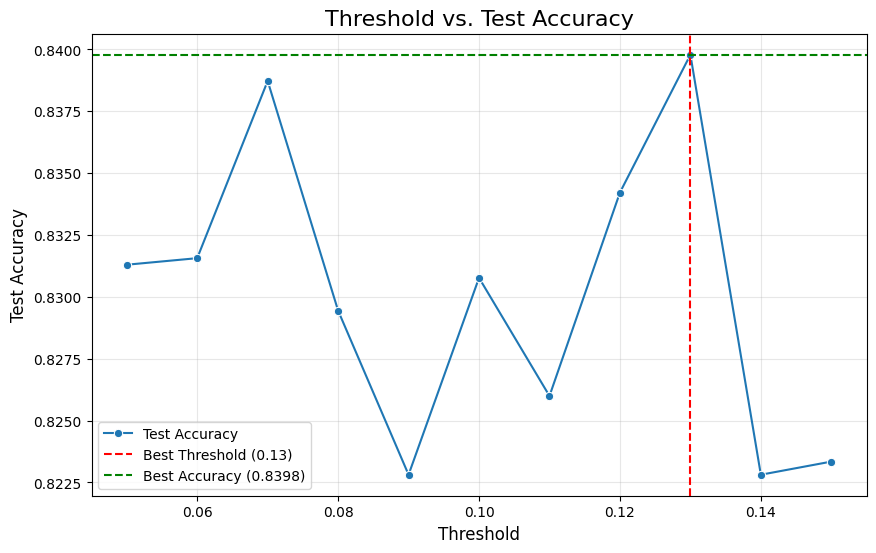

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [float(k) for k in all_thresholds_results.keys()]
test_accuracies = [v['avg_test_accuracy'] for v in all_thresholds_results.values()]
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=test_accuracies, marker="o", label="Test Accuracy")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold ({best_threshold:.2f})")
plt.axhline(best_test_accuracy, color='green', linestyle='--', label=f"Best Accuracy ({best_test_accuracy:.4f})")
plt.title("Threshold vs. Test Accuracy", fontsize=16)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


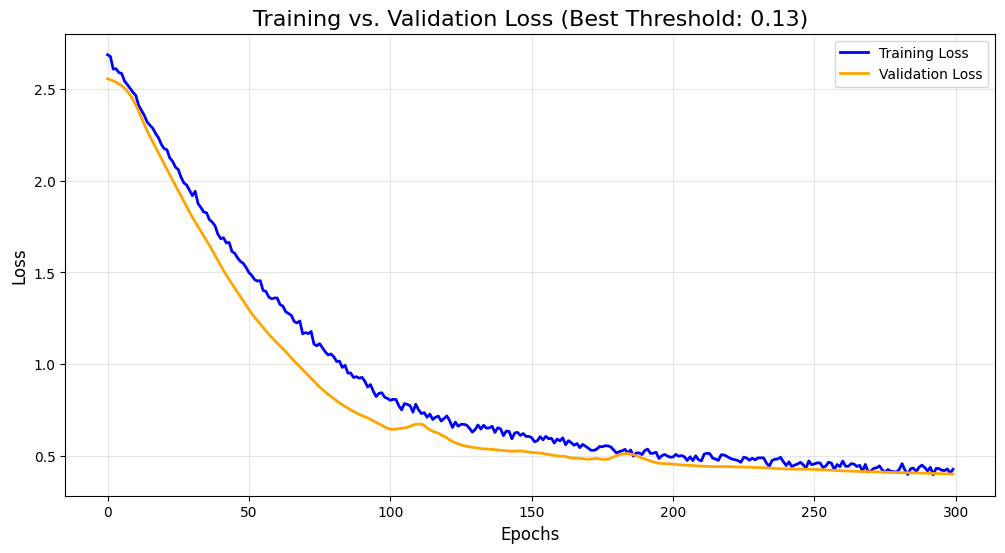

In [14]:

with open(f'training_history/history_threshold_{0.07}.json', 'r') as f:
    best_history = json.load(f)


train_losses = best_history['train_loss']
val_losses = best_history['val_loss']
epochs = range(len(train_losses))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Training Loss", color='blue', linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", color='orange', linewidth=2)
plt.title(f"Training vs. Validation Loss (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


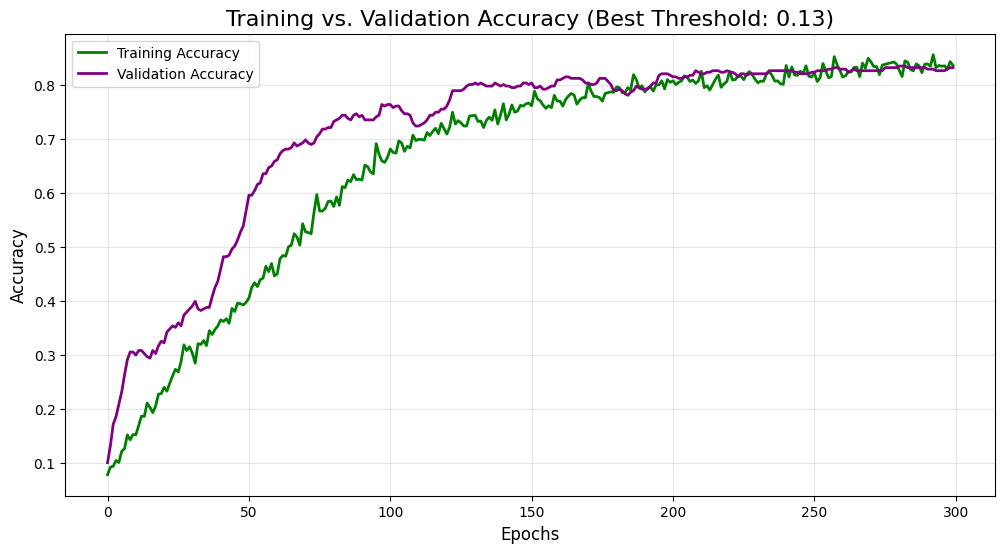

In [15]:
train_acc = best_history['train_acc']
val_acc = best_history['val_acc']
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label="Training Accuracy", color='green', linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", color='purple', linewidth=2)
plt.title(f"Training vs. Validation Accuracy (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


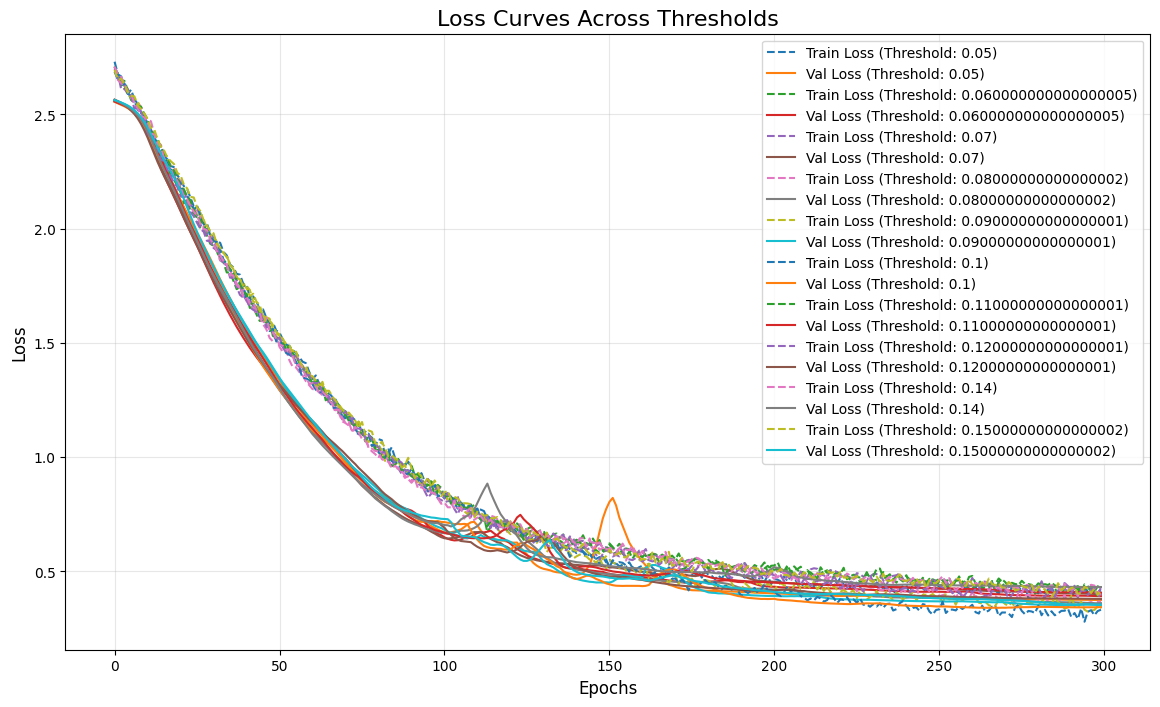

In [25]:
import numpy as np
plt.figure(figsize=(14, 8))

train_info = {}
val_info = {}
for i in np.arange(0.05, 0.16, 0.01):
    if i != 0.13:
        with open(f'training_history/history_threshold_{i:.2f}.json', 'r') as f:
            best_history = json.load(f)
        train_info[i] = best_history['train_loss']
        val_info[i] = best_history['val_loss']            
        
for (k1, v1), (k2, v2) in zip(train_info.items(), val_info.items()):
    train_loss = v1
    val_loss = v2
    plt.plot(train_loss, label=f"Train Loss (Threshold: {k1})", linestyle='--')
    plt.plot(val_loss, label=f"Val Loss (Threshold: {k1})", linestyle='-')

plt.title("Loss Curves Across Thresholds", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.show()


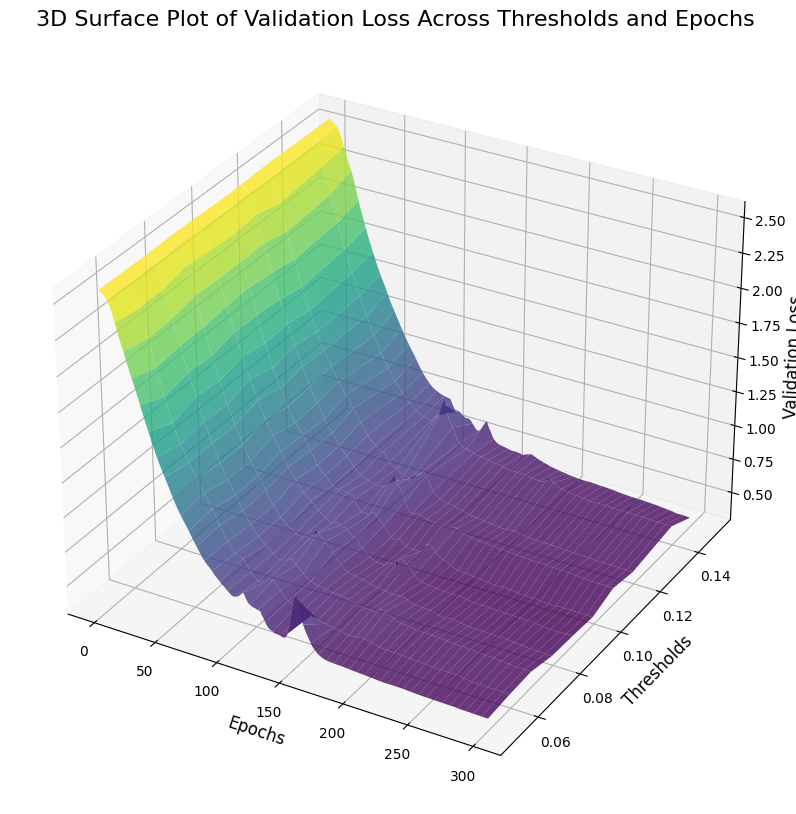

In [29]:
from mpl_toolkits.mplot3d import Axes3D

thresholds = np.array([t for t in thresholds if t != 0.13])
epochs = np.arange(len(train_losses))
X, Y = np.meshgrid(epochs, thresholds)
Z = np.array([val_info[threshold] for threshold in thresholds if threshold != 0.13])
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.8)
ax.set_title("3D Surface Plot of Validation Loss Across Thresholds and Epochs", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Thresholds", fontsize=12)
ax.set_zlabel("Validation Loss", fontsize=12)
plt.show()


In [30]:
import shutil
shutil.make_archive('working_dir', 'zip', '/kaggle/working')

'/kaggle/working/working_dir.zip'